In [1]:
import sys
sys.path.append('..')
import pandas as pd

from utils.preprocessing import PreprocessingPipeline
from utils.feature_extraction import compute_features
from feature_selection.fisher_score import fisher_score

In [2]:
NTP_INTERVALS = {
    '1_marco': ('2024-05-28 15:21:46.830', '2024-05-28 15:36:21.000'),
    '2_svenja': ('2024-05-28 15:39:02.218', '2024-05-28 15:52:16.613'),
    '3_konstantin': ('2024-05-28 15:56:31.000', '2024-05-28 16:09:37.000'),
    '4_aleyna': ('2024-05-28 16:11:26.149', '2024-05-28 16:21:35.000'),
}

pipeline = PreprocessingPipeline(ntp_intervals=NTP_INTERVALS)
X, y = pipeline.get_full_data()
y = y.astype(str)
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (6125, 100, 6)
y shape: (6125,)


In [3]:
# Extract features
X_features = compute_features(X)

  0%|          | 0/6125 [00:00<?, ?it/s]/opt/miniconda3/envs/ct-env/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
100%|██████████| 6125/6125 [00:20<00:00, 298.86it/s]


## Fisher Score (Supervised feature selection algorithm)

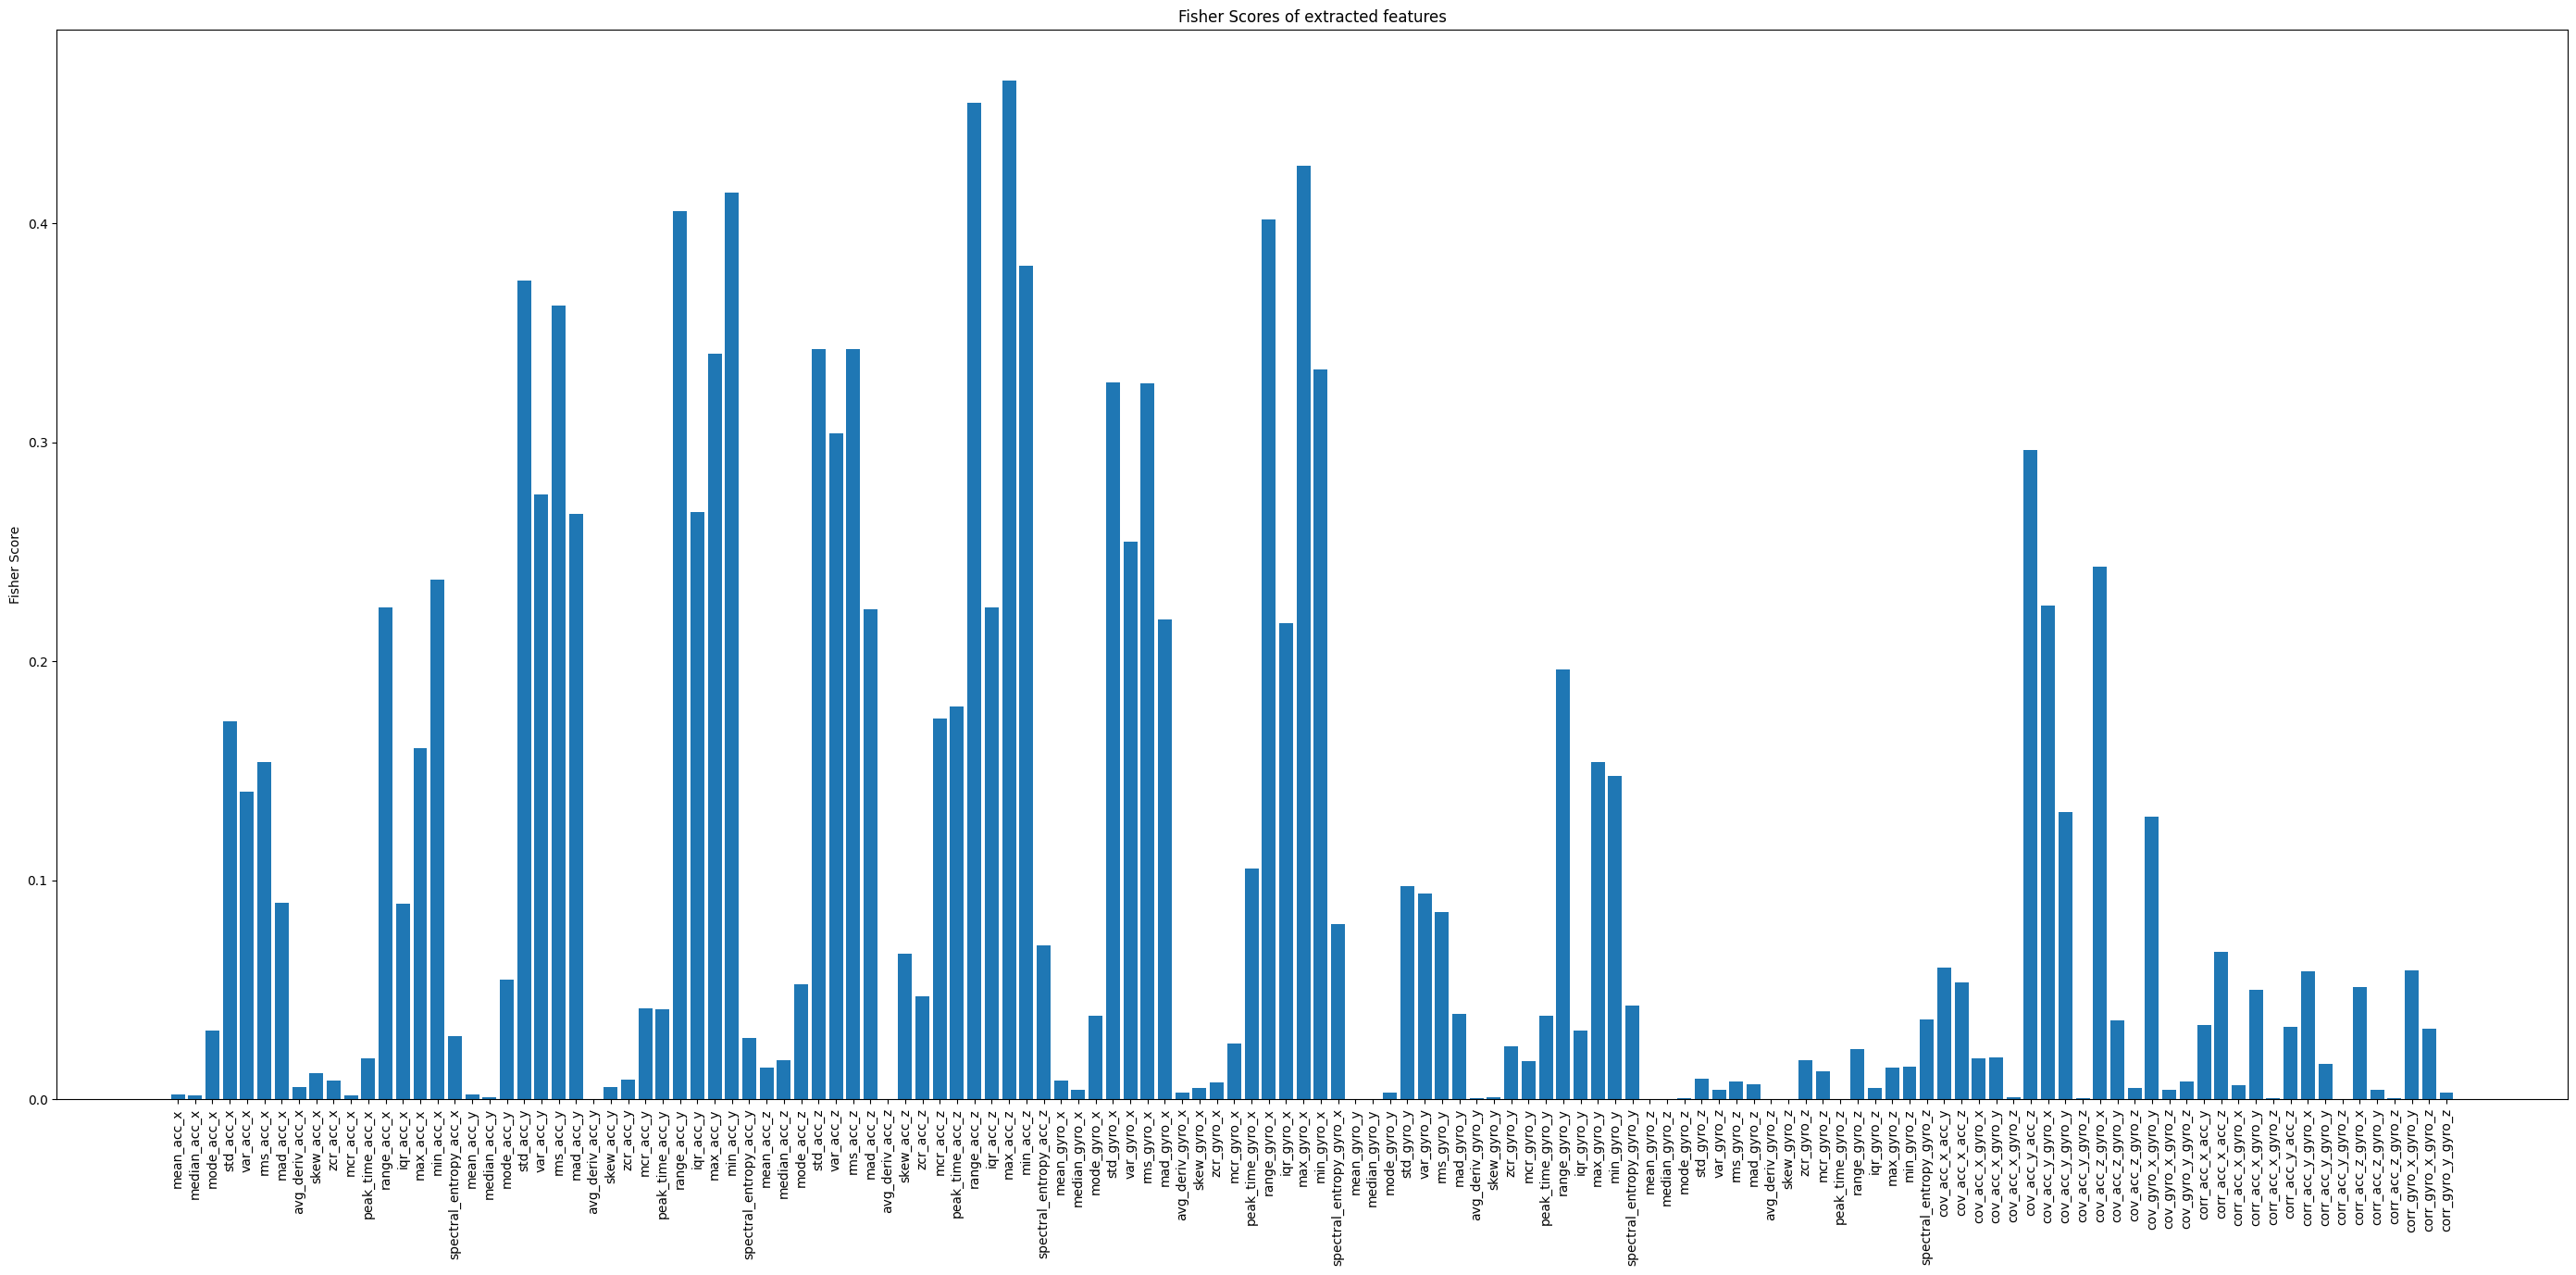

In [4]:
import matplotlib.pyplot as plt

fisher_scores = fisher_score(X_features, y)

# bar plot of fisher scores
plt.figure(figsize=(35, 15))
plt.title('Fisher Scores of extracted features')
plt.bar(X_features.columns, fisher_scores)
plt.ylabel('Fisher Score')
plt.xticks(rotation=90)
plt.show()

max_acc_z: 0.4650453635903755
range_acc_z: 0.45482415909572854
max_gyro_x: 0.4260763742724796
min_acc_y: 0.4138292205415692
range_acc_y: 0.4055283935305604
range_gyro_x: 0.40182269257701786
min_acc_z: 0.3805439390103963
std_acc_y: 0.37387572128356567
rms_acc_y: 0.36219029464493324
rms_acc_z: 0.3426630932911913


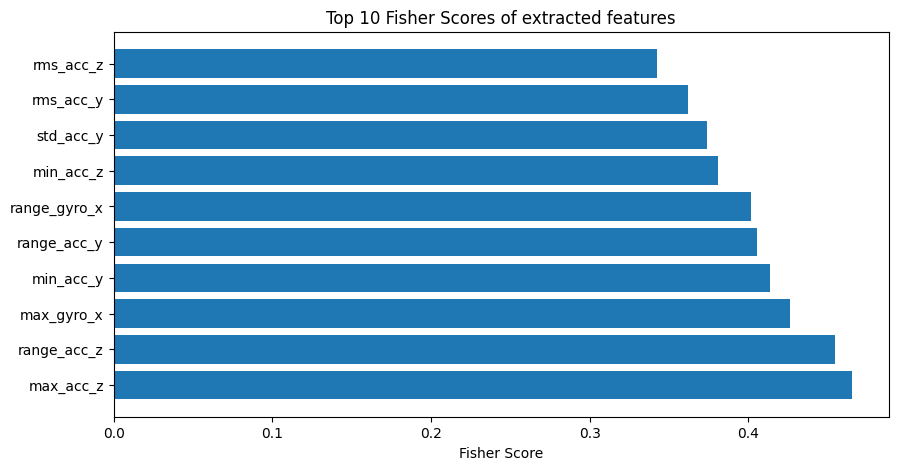

In [5]:
# Print top 10 features
top_10_features = fisher_scores.argsort()[::-1][:10]
for feat in top_10_features:
    print(f'{X_features.columns[feat]}: {fisher_scores[feat]}')

# horizontal bar plot of best 10 features
plt.figure(figsize=(10,5 ))
plt.title('Top 10 Fisher Scores of extracted features')
plt.barh(X_features.columns[top_10_features], fisher_scores[top_10_features])
plt.xlabel('Fisher Score')

# plt.savefig('../results/fisher_scores.png')
plt.show()

## PCA (Unsupervised dimensionality reduction algorithm)

In [6]:
from sklearn.decomposition import PCA

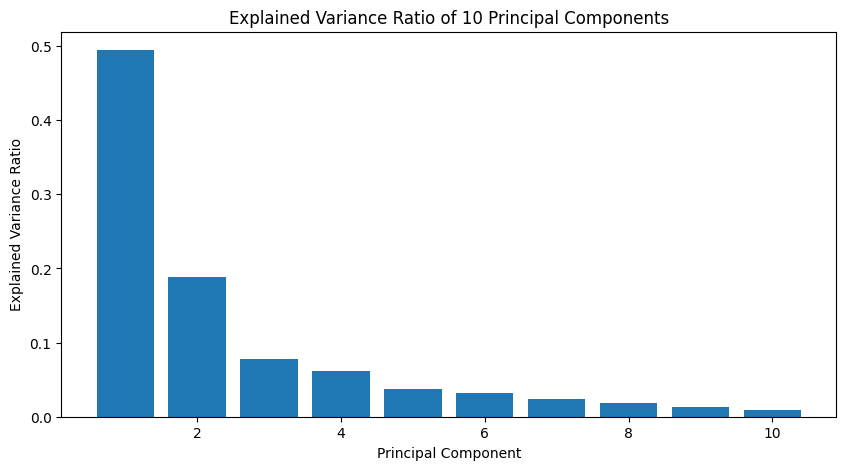

In [19]:
n_components = 10

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_features)

# plot the explained variance ratio
plt.figure(figsize=(10, 5))
plt.bar(range(1, 11), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title(f'Explained Variance Ratio of {n_components} Principal Components')
# plt.savefig('../results/explained_variance_ratio.png')
plt.show()

In [20]:
# compute reconstruction error
from sklearn.metrics import root_mean_squared_error

X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_error = root_mean_squared_error(X_features, X_reconstructed)
print(f'Reconstruction error: {reconstruction_error}')

Reconstruction error: 0.5071313314180665


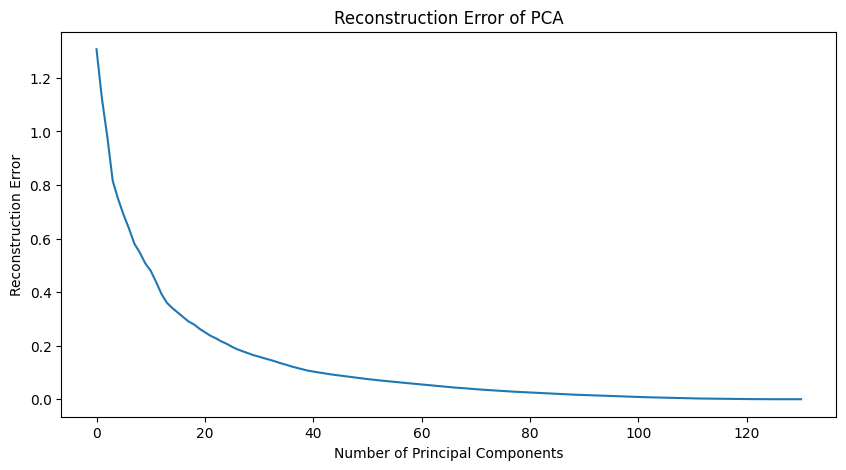

In [9]:
# elbow method to determine optimal number of components
reconstruction_errors = []

for i in range(1, len(X_features.columns)):
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X_features)
    X_reconstructed = pca.inverse_transform(X_pca)
    reconstruction_error = root_mean_squared_error(X_features, X_reconstructed)
    reconstruction_errors.append(reconstruction_error)

plt.figure(figsize=(10, 5))
plt.plot(reconstruction_errors)
plt.xlabel('Number of Principal Components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error of PCA')
# plt.savefig('../results/pca_reconstruction_error.png')
plt.show()

## Recursive Feature Elimination with SVC

In [10]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

svc = SVC(kernel="linear", C=1)
svm_selector = RFE(estimator=svc, n_features_to_select=10, step=1)
X_train_svm = svm_selector.fit_transform(X_features, y)

print(X_features.columns[svm_selector.support_])

Index(['std_acc_y', 'rms_acc_y', 'mad_acc_y', 'rms_acc_z', 'peak_time_acc_z',
       'std_gyro_x', 'mad_gyro_x', 'cov_acc_y_gyro_x', 'cov_acc_z_gyro_z',
       'corr_acc_y_gyro_x'],
      dtype='object')


## Sequential Feature Selection with KNN

In [11]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

In [12]:
sfs = SequentialFeatureSelector(estimator=KNeighborsClassifier(), n_features_to_select=10)
X_train_sfs = sfs.fit_transform(X_features, y)
X_features.columns[sfs.get_support()]

Index(['mean_acc_y', 'std_acc_y', 'iqr_acc_y', 'avg_deriv_acc_z', 'zcr_acc_z',
       'mean_gyro_x', 'mad_gyro_x', 'cov_acc_y_acc_z', 'corr_acc_y_acc_z',
       'corr_acc_z_gyro_z'],
      dtype='object')

In [23]:
# Save each set of selected features in json file
selected_features = {
    'fisher_scores': X_features.columns[top_10_features].tolist(),
    'pca': X_features.columns[:n_components].tolist(),
    'svm': X_features.columns[svm_selector.support_].tolist(),
}

pd.DataFrame(selected_features).to_json('../results/selected_features.json')